# Resolve simple games using Deep Reinforcement Learning

#### Loading required libraries

In [12]:
# Tested with python 3.9.6
!pip3 install numpy"==1.26.4" matplotlib=="3.8.4" gym"==0.26.2" tqdm"==4.66.2" pygame"==2.5.2" setuptools"==69.5.1" tensorflow"==2.16.1" keras"==3.3.3"
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf
from collections import deque
import random
import pygame

Defaulting to user installation because normal site-packages is not writeable


In [13]:
print(f"Num GPUs Available fo version {tf.__version__}: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available fo version 2.16.1: 0


#### Analysing our environment

In [14]:
def create_env(show, max_episode_steps = 10000):
    if show:
        return gym.make('CartPole-v1', max_episode_steps = max_episode_steps, render_mode = "human")
    else:
        return gym.make('CartPole-v1', max_episode_steps = max_episode_steps, render_mode = None)

env = create_env(show = False)
print(f"{env.observation_space.shape[0]} states")
print(f"{env.action_space.n} actions")
env.close()

4 states
2 actions


In [15]:
def play_with_random_actions():
    env = create_env(show = True)
    
    rewards = 0
    env.reset()
    done = False
    while not done:
        env.render()
        
        action = env.action_space.sample()
        _, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        rewards += reward

    print(f"Reward is {rewards}")

    env.close()

# play_with_random_actions()

#### Training (optional)

In [16]:
class DRLAgent():

    def __init__(self, model_path = None):

        env = create_env(show = False)
        self.state_size =  env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # parameters and hyperparameters
        self.episodes_nb = 100
        self.max_episode_steps = 500
        self.batch_size = 16
        self.gamma = 0.95
        self.learning_rate = 0.001

        # this part is for epsilon()
        self.epsilon_max = 1
        self.epsilon_min = 0.01
        self.epsilon_decay_factor = (self.epsilon_min / self.epsilon_max) ** (1 / self.episodes_nb)

        # a list with 1000 memory, if it becomes full first inputs will be deleted
        self.memory = deque(maxlen = 1000)

        if model_path:
            print(f"Loading pre-trained model {model_path}")
            self.model = load_model(model_path)
        else:
            print(f"Loading new model")
            self.model = Sequential()
            self.model.add(Dense(32, activation="relu", input_dim=self.state_size))
            self.model.add(Dense(32, activation="relu"))
            self.model.add(Dense(self.action_size, activation="linear"))
            self.model.compile(loss = 'mse', optimizer = Adam(learning_rate = self.learning_rate))

    # computes the epsilon value to use for a dedicated episode
    def epsilon(self, episode):
        return self.epsilon_max * self.epsilon_decay_factor ** episode

    # computes the action to do: acting, exploit or explore
    def act(self, env, state, episode):
        if random.uniform(0,1) <= self.epsilon(episode):
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state, verbose = 0)
            return np.argmax(act_values[0])

    # add transition data to the cache list
    def add_to_cache(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # trains our model with the latest memory 
    def train_with_cache(self):

        # do nothing memory is still not full
        if len(self.memory) < self.batch_size:
            return 

        # take batch_size random samples from memory
        minibatch = random.sample(self.memory, self.batch_size) 
        for state, action, reward, next_state, done in minibatch:

            # if the game is over, we just use the reward
            if done: 
                target = reward
            else:
                # target = R(s,a) + gamma * max Q`(s`,a`)
                # target (max Q` value) is output of Neural Network which takes s` as an input
                # amax(): flatten the lists (make them 1 list) and take max value
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose = 0)[0])

            train_target = self.model.predict(state, verbose = 0) 
            train_target[0][action] = target

            # train our model to predict target from a given state 
            self.model.fit(state, train_target, epochs = 1, verbose = 0)        

Loading new model


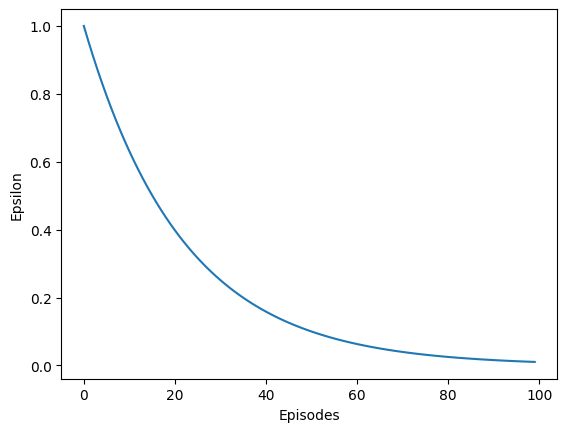

In [17]:
def display_epsilon_strategy():
    agent = DRLAgent()

    epsilons = [ agent.epsilon(episode) for episode in range(agent.episodes_nb) ]

    plt.plot(epsilons)
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon")
    plt.show()

display_epsilon_strategy()

In [18]:
def display_observations(rewards, by):
    rewards_mean = [ np.mean(rewards[i : i + by]) for i in range(0, len(rewards), by) for _ in range(by) ]
    
    fig = plt.figure(1)
    plt.plot(rewards_mean)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    
    return fig

In [19]:
def train(start_episode, end_episode, update_offset):

    # initialize env
    env = create_env(show = False)

    # initialize agent
    if start_episode > 0:
        agent = DRLAgent(model_path = f"model_e{start_episode - 1}.keras")
    else:
        agent = DRLAgent(model_path = None)
        
    # Verify arguments validity
    assert(0 <= start_episode)
    assert(end_episode <= agent.episodes_nb)
    assert(0 < update_offset < end_episode - start_episode)

    # evaluation array
    total_rewards = list()

    for episode in tqdm(range(start_episode, end_episode + 1, 1)):

        # initialize environment
        state, _ = env.reset()
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        rewards = 0
        done = False

        while not done:

            # act
            action = agent.act(env, state, episode)

            # step
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            done = terminated or truncated

            # storage
            agent.add_to_cache(state, action, reward, next_state, done)

            # update state, reward and steps
            state = next_state
            rewards += reward

            # replay
            agent.train_with_cache()
            
        total_rewards.append(rewards)

        ## Plot reward vs episodes
        if (episode != 0 and episode % update_offset == 0):
            fig = display_observations(total_rewards[0 : episode - start_episode + 1], (end_episode - start_episode) // 25)
            fig.savefig("results/rewards.png")
            agent.model.save(f"results/model_e{episode}.keras")

    agent.model.save("results/model_latest.keras")

    return agent

# agent = train(start_episode = 0, end_episode = 100, update_offset = 1)

#### Play with our trained AI (optional)

In [20]:
agent = DRLAgent("results/model_e65.keras")

Loading pre-trained model results/model_e65.keras


In [21]:
def play_with_drl(model):
    env = create_env(show = True)

    rewards = 0
    state, _ = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])

    done = False
    while not done:
        env.render()

        action = np.argmax(model.predict(state, verbose = 0)[0])
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        done = terminated or truncated

        rewards += reward
        state = next_state

    print(f"Reward is {rewards}")
    env.close()

play_with_drl(agent.model)

Reward is 157.0


In [22]:
pygame.quit()

: 